In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

import utils.datasets_utils as datasets_utils
import utils.classification_utils as classification_utils

sns.set_palette("Set2")
sns.set_style("whitegrid")

In [2]:
datasets = datasets_utils.load_datasets()
datasets_wrapper = datasets_utils.DatasetsWrapper(datasets)

In [3]:
datasets_wrapper.get_shapes()

,train_X,val_X,test_X,train_y,val_y,test_y
spectral_original,"(21572, 196)","(2397, 196)","(5993, 196)","(21572,)","(2397,)","(5993,)"
all_original,"(21572, 294)","(2397, 294)","(5993, 294)","(21572,)","(2397,)","(5993,)"
pca_original,"(21572, 141)","(2397, 141)","(5993, 141)","(21572,)","(2397,)","(5993,)"
umap_original,"(21572, 15)","(2397, 15)","(5993, 15)","(21572,)","(2397,)","(5993,)"
spectral_modified,"(20714, 196)","(2397, 196)","(5993, 196)","(20714,)","(2397,)","(5993,)"
all_modified,"(20714, 294)","(2397, 294)","(5993, 294)","(20714,)","(2397,)","(5993,)"
pca_modified,"(20714, 140)","(2397, 140)","(5993, 140)","(20714,)","(2397,)","(5993,)"
umap_modified,"(20714, 15)","(2397, 15)","(5993, 15)","(20714,)","(2397,)","(5993,)"


In [4]:
# label_encoder = LabelEncoder()
# datasets_wrapper.encode_labels(encoder=label_encoder)

Scaling helps convergence for logistic regression

In [5]:
scaler = StandardScaler()
datasets_wrapper.scale_datasets(scaler)

# 1. Training

In [6]:
classifiers = [classification_utils.ClassifierFactory.create_instance(
    dataset=dataset, 
    classifier=LogisticRegression(multi_class='multinomial', solver='sag', random_state=123, max_iter=500),
) for dataset in datasets]

In [7]:
cl_collection = classification_utils.ClassifiersCollection(classifiers)

In [8]:
cl_collection.fit_classifiers()

Fitting classifiers...


  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\kblazhev\Desktop\deletable pr\Music-Genre-Classification-master\Music-Genre-Classification-master\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▎        | 1/8 [01:39<11:37, 99.59s/it]c:\Users\kblazhev\Desktop\deletable pr\Music-Genre-Classification-master\Music-Genre-Classification-master\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 2/8 [04:07<12:48, 128.14s/it]c:\Users\kblazhev\Desktop\deletable pr\Music-Genre-Classification-master\Music-Genre-Classification-master\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 4/8 [05:23<04:13, 63.29s/it] c:\Users\kblazhev\Desktop\de

Done


In [9]:
# datasets_wrapper.reverse_encode_labels()

# 2. Results

In [10]:
evaluation_df = cl_collection.evaluate_classifiers()

In [11]:
evaluation_df[[dataset.name for dataset in datasets if 'original' in dataset.name]]

spectral_original                     all_original  \
                                 train       val      test        train   
accuracy                      0.644354  0.628703  0.620057     0.661088   
precision (weighted)          0.621727  0.608404  0.589095     0.641911   
recall (weighted)             0.644354  0.628703  0.620057     0.661088   
f1 (weighted)                 0.621204  0.607022  0.595413     0.641241   

                                         pca_original                      \
                           val      test        train       val      test   
accuracy              0.647893  0.635909     0.635685  0.618273  0.617053   
precision (weighted)  0.631851  0.609027     0.611142  0.592432  0.589993   
recall (weighted)     0.647893  0.635909     0.635685  0.618273  0.617053   
f1 (weighted)         0.628184  0.614154     0.611526  0.591814  0.591094   

                     umap_original                      
                             train       val      test  
accuracy                  0.528787  0.520651  0.520274  
precision (weighted)      0.464177  0.452751  0.467492  
recall (weighted)         0.528787  0.520651  0.520274  
f1 (weighted)             0.480335  0.472911  0.474821

In [12]:
evaluation_df[[dataset.name for dataset in datasets if 'modified' in dataset.name]]

spectral_modified                     all_modified  \
                                 train       val      test        train   
accuracy                      0.611422  0.595327  0.578508     0.646278   
precision (weighted)          0.601466  0.610066  0.598899     0.640603   
recall (weighted)             0.611422  0.595327  0.578508     0.646278   
f1 (weighted)                 0.602519  0.598850  0.584578     0.640404   

                                         pca_modified                      \
                           val      test        train       val      test   
accuracy              0.616187  0.595528     0.598774  0.589487  0.580177   
precision (weighted)  0.635321  0.618613     0.588617  0.605226  0.598164   
recall (weighted)     0.616187  0.595528     0.598774  0.589487  0.580177   
f1 (weighted)         0.621820  0.602597     0.589276  0.592598  0.584741   

                     umap_modified                      
                             train       val      test  
accuracy                  0.467075  0.485607  0.490072  
precision (weighted)      0.420905  0.480308  0.476593  
recall (weighted)         0.467075  0.485607  0.490072  
f1 (weighted)             0.415487  0.463219  0.466730

- All Original

In [13]:
all_original_classifier = cl_collection.get_classifier('all_original')

In [14]:
all_original_classifier.get_clf_evaluation().get_scores()

,train,val,test
accuracy,0.661088,0.647893,0.635909
precision (weighted),0.641911,0.631851,0.609027
recall (weighted),0.661088,0.647893,0.635909
f1 (weighted),0.641241,0.628184,0.614154


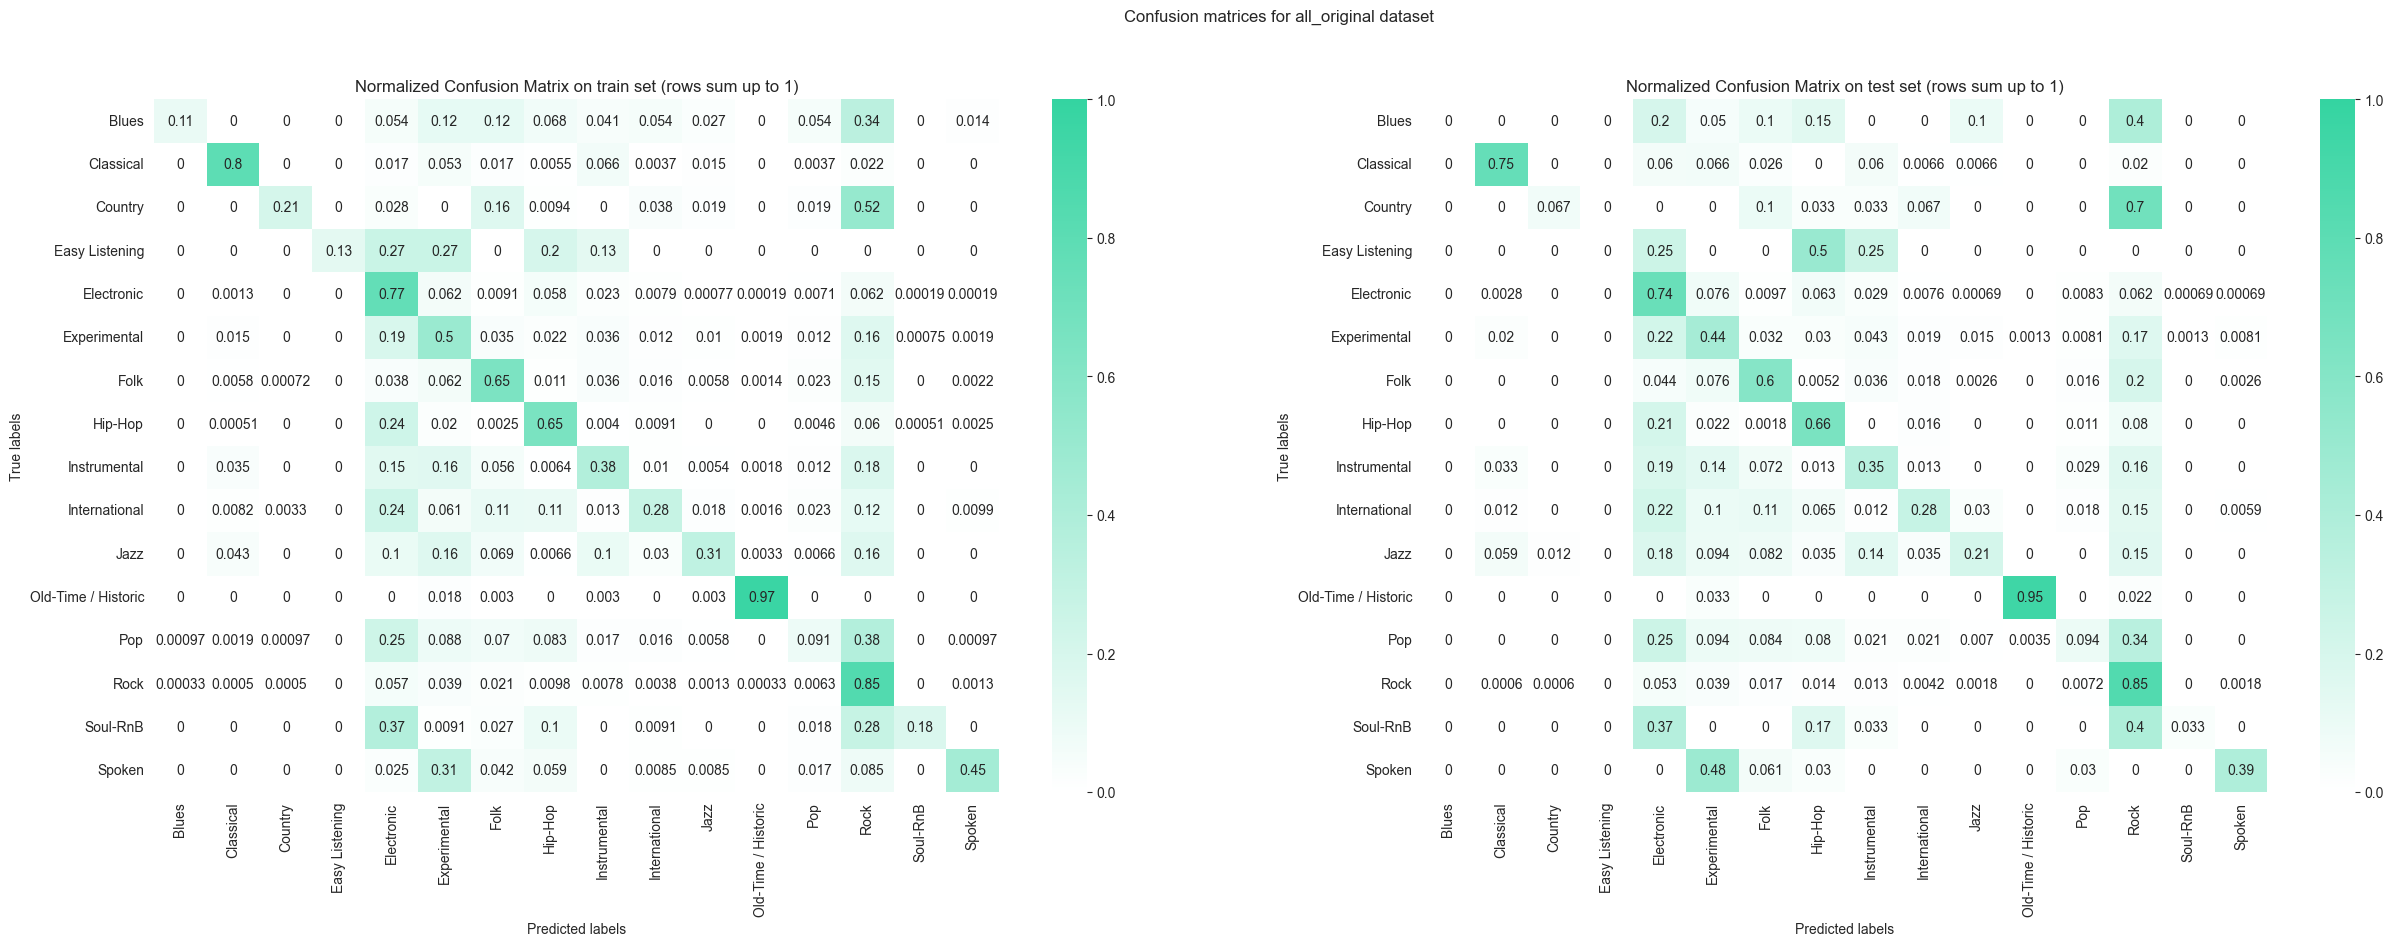

In [15]:
fig, axis = plt.subplots(1, 2, figsize=(30, 9))
all_original_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[0], on_set='train')
all_original_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[1], on_set='test')
fig.suptitle('Confusion matrices for all_original dataset')
plt.show()

Metrics on train set

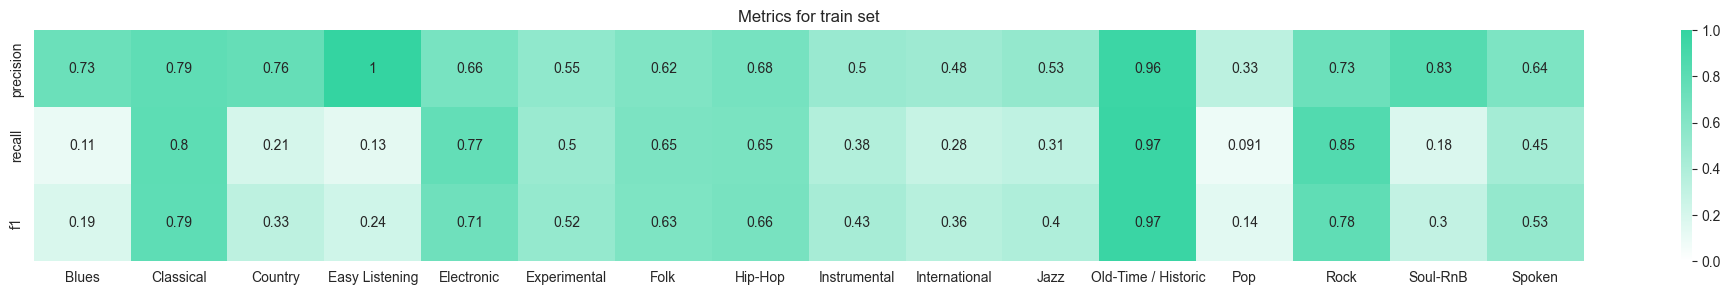

In [16]:
_, ax = plt.subplots(1, 1, figsize=(25, 3))
all_original_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax, on_set='train')
plt.show()

Metrics on test set

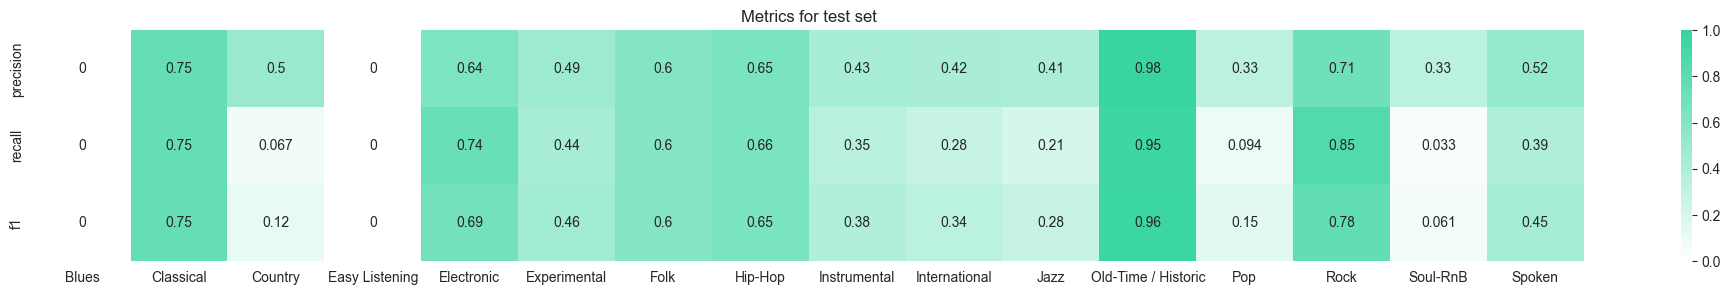

In [17]:
_, ax = plt.subplots(1, 1, figsize=(25, 3))
all_original_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax, on_set='test')
plt.show()

# 3. Model Confidence

In [18]:
clf = all_original_classifier.classifier
test_X = all_original_classifier.dataset.test.X
test_y = all_original_classifier.dataset.test.y

predicted_proba = pd.DataFrame(clf.predict_proba(test_X), columns=sorted(test_y.unique().tolist()), index=test_X.index)

# For each row, assign the column whose value for the predicted probability is the highest
predicted_proba['genre'] = predicted_proba.idxmax(axis=1)

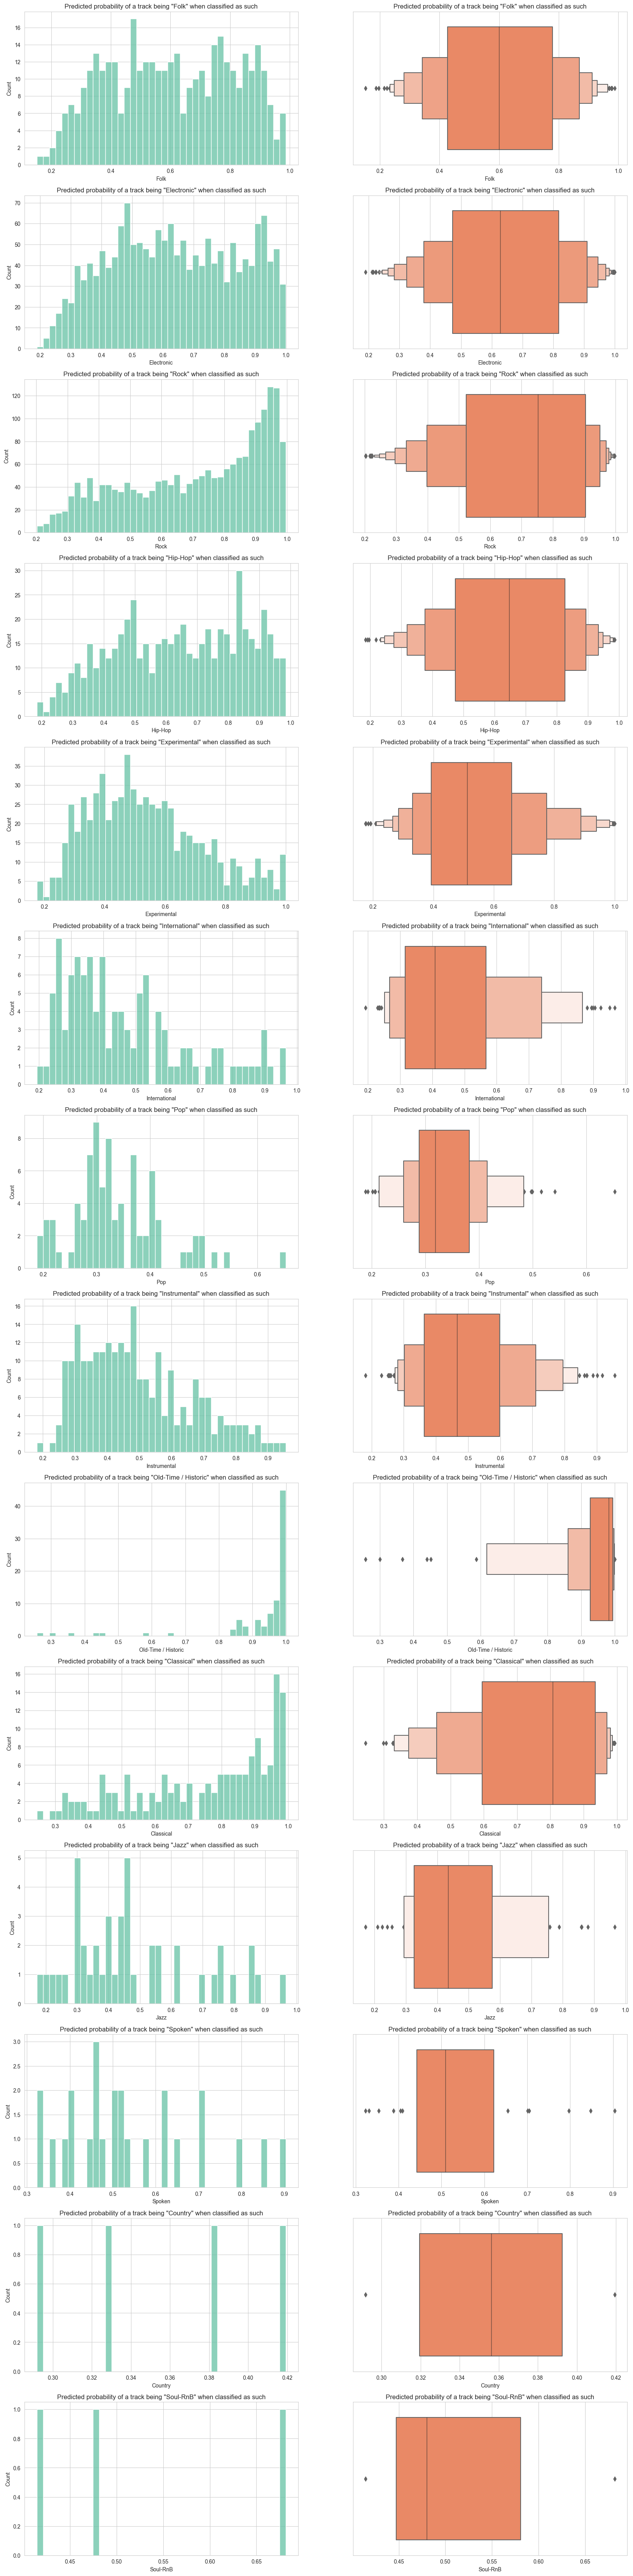

In [19]:
num_genres = predicted_proba['genre'].nunique()
ax_idxs = [(i, j) for i in range(num_genres) for j in range(2)]

fig, axs = plt.subplots(num_genres, 2, figsize=(20, 85))

k = 0
for genre in predicted_proba['genre'].unique():
    ax1_idx, ax2_idx = ax_idxs[k], ax_idxs[k + 1]
    ax1, ax2 = axs[ax1_idx[0]][ax1_idx[1]], axs[ax2_idx[0]][ax2_idx[1]]

    ax1.set_title(f'Predicted probability of a track being "{genre}" when classified as such')
    ax2.set_title(f'Predicted probability of a track being "{genre}" when classified as such')

    sns.histplot(x=predicted_proba[predicted_proba['genre'] == genre][genre], bins=40, ax=ax1)
    sns.boxenplot(x=predicted_proba[predicted_proba['genre'] == genre][genre], color='coral', ax=ax2)
    k += 2